In [2]:
# Time Independent Schrodinger Equation
# Computational Physics Project 2

import numpy as np
import scipy as sp
from scipy.integrate import odeint
from scipy.integrate import simps
from scipy.optimize import brentq,brenth
from scipy.special import airy
import matplotlib.pyplot as plt

In [68]:
L = 10.0 # length
nx = 100 # number of grid points

x = np.linspace(0,L,nx) # grid
psi0 = 0; u0 = 1; # define initial conditions
init = np.array([psi0,u0]) # 
E = 1

# potential function
def V(x):
    return linear(x)
    
def linear(x):
    if x==0:
        return 1000
    else:
        return x
    
def harmonic(x):
    return x**2

# psi update function
def f(psi,u,x,E):
    return u

# u update function
def g(psi,u,x,E):
    return 2*(V(x)-E)*psi

In [69]:
# return derivatives for odeint
def deriv(sol,x,E):
    psi,u = sol
    dpsi = f(psi,u,x,E)
    du = g(psi,u,x,E)
    
    return np.array([dpsi,du])

# solves ode for given E
def odeSolve(init,x,E):
    sol = odeint(deriv,init,x,args=(E,))
    
    return sol

sol = odeSolve(init,x,E)
psi = sol[:,0]; u = sol[:,1]

In [70]:
# solves ode for given E and returns value "at L"
def at_L(E,init,x):
    sol = odeint(deriv,init,x,args=(E,))
    
    return sol[-1,0]

EMax = 10; nE = 200; # maximum and number of values to calculate for energy
energies = np.linspace(0,EMax,nE) # array of energies
psiE = np.zeros(nE) # initialize array

for i in range(nE):
    psiE[i] = at_L(energies[i],init,x)
    

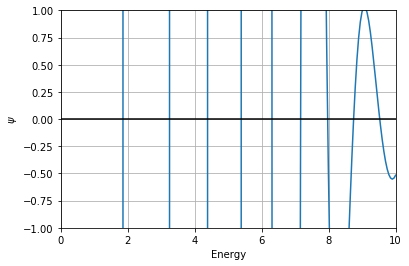

In [71]:
# Plot solution at L as function of E

plt.plot(energies,psiE)
plt.xlabel("Energy"); plt.ylabel(r"$\psi$")
plt.xlim([0,EMax]); plt.ylim([-1,1]);

plt.axhline(0, color='k')
plt.grid(True); plt.show();

[ 1.85575704  3.24460765  4.38167126  5.38661375  6.30526321  7.16129822
  7.96939738  8.74498661  9.52575048]


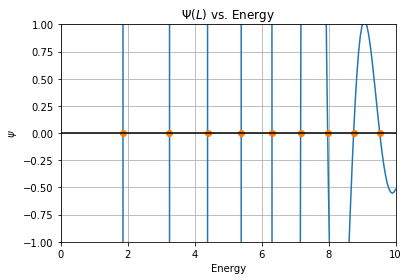

In [99]:
# Root finding

def rootFinder(x,EMax,init,numE=np.inf,a=0.1,b=0.2,incr=0.1):
    roots = np.empty(0)
    
    while b < EMax and roots.size < numE:
        if (np.sign(at_L(a,init,x)) != np.sign(at_L(b,init,x))):
            root = brentq(at_L,a,b,args=(init,x))
            #root = bisect(at_L,a,b,args=(init,x))
            #root = brenth(at_L,a,b,args=(init,x))
            roots = np.append(roots,root)
            a = b; b += incr
        else:
            b += incr
        
    return roots
    
roots = rootFinder(x,EMax,init)

print(roots)
plt.plot(energies,psiE)
plt.plot(roots,np.zeros(roots.size), 'o')
plt.xlabel("Energy"); plt.ylabel(r"$\psi$")
plt.xlim([0,EMax]); plt.ylim([-1,1]);
plt.title(r"$\Psi(L)$ vs. Energy")
plt.axhline(0, color='k')
plt.grid(True); plt.show();

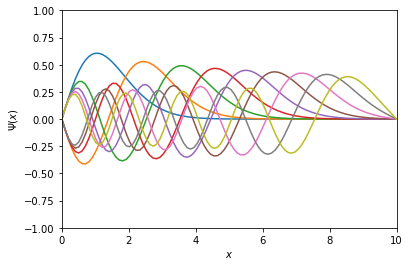

In [100]:
# Plot wavefunction for each energy
sols = np.zeros([nx,roots.size])

for i in range(roots.size):
    if i % 2 != 0:
        init[1] = -1
        sol = odeSolve(init,x,roots[i])
    else:
        init[1] = 1
        sol = odeSolve(init,x,roots[i])
        
    psi = sol[:,0]; u = sol[:,1]
    sols[:,i] = psi
  
plt.plot(x,sols)
plt.xlabel(r"$x$"); plt.ylabel(r"$\Psi(x)$");
plt.xlim(0,L); plt.ylim(-1,1);
#plt.legend()
plt.show()

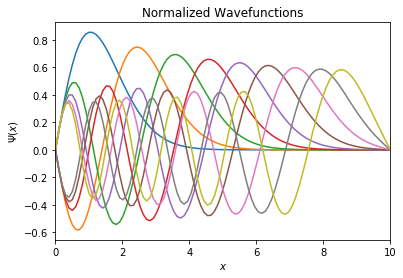

In [101]:
# Normalize wavefunctions
normList = np.zeros(roots.size)

for i in range(roots.size):
   normList[i] = simps(sols[:,i]**2,x)

normSols = sols / np.sqrt(normList)

plt.plot(x,normSols)
plt.xlabel(r"$x$"); plt.ylabel(r"$\Psi(x)$");
plt.xlim(0,L)
plt.title("Normalized Wavefunctions")
#plt.legend()
plt.show()

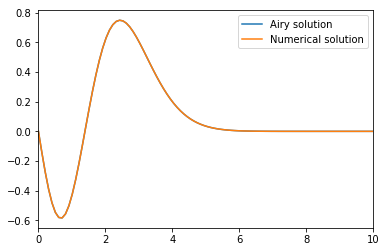

In [102]:
# Compare with analytical solution using Airy functions

#for i in range(roots.size):
#    xsub = 2*(x-roots[i])
#    solA = airy(xsub)[0]
#    plt.plot(xsub,solA)

level = 2 # select energy level
xsub = 2*(x-roots[level-1]) / 2**(2/3)
solA = airy(xsub)[0]
norm = simps(solA**2,x)
normSolA = solA / np.sqrt(norm)

plt.plot(x,normSolA,label="Airy solution");
plt.plot(x,normSols[:,level-1],label="Numerical solution")
plt.xlim(0,L)
plt.legend()
plt.show()

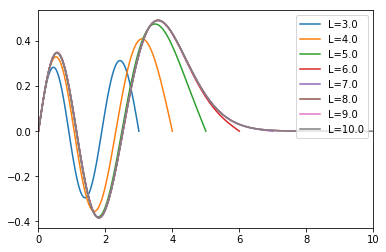

In [109]:
numL = 10 # number of lengths to test
maxL = 10 # maximum length to test
Ls = np.linspace(1,maxL,numL) # array of lengths
eig = 3 # select which energy level

for i in range(numL):
    try:
        x = np.linspace(0,Ls[i],nx) # grid
        roots = rootFinder(x,EMax,init,numE=eig)
        sol = odeSolve(init,x,roots[eig-1])
        psi = sol[:,0]
        plt.plot(x,psi,label="L="+str(np.around(Ls[i],2)))
    except IndexError:
        pass
            
plt.xlim(0,maxL)
plt.legend()
plt.show()